### **Importing Necessary Libraries**

In [1]:
# !pip install cryptocmd
# !pip install yfinance

from cryptocmd import CmcScraper
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
from dateutil.relativedelta import relativedelta

from scipy.stats import norm
from scipy.optimize import minimize
import math

%matplotlib inline
from IPython.core.pylabtools import figsize

### **Data Extraction and Transformation to get CLEAN DATA**


In [5]:
def generate_coins(start_date, end_date):
  # end = datetime.strptime(start_date, '%Y-%m-%d').date() + relativedelta(months=window)
  # end_date = end.strftime('%Y-%m-%d')
  # nci_coin_list = ['BTC', 'ETH', 'LTC', 'LINK', 'UNI', 'BCH', 'XLM', 'FIL', 'AXS', 'SAND']
  tmp = pd.read_excel('final_classification_df.xlsx', parse_dates=True)

  allCoins = tmp[["Date", "Close", "Volume", "Market Cap", "Coin"]]
  allCoins = allCoins[(allCoins["Date"] >= start_date) & (allCoins["Date"] <= end_date)]

  return allCoins

def gen_etf(start_date, end_date):  
  #bond ETF: BSV[Vanguard Short-Term Bond ETF], BND[Vanguard Total Bond Market ETF], SPDR GLD shares
  etfs = ['spy', 'bsv', 'bnd', 'gld', '^tnx', 'brt', 'kweb']

  etf_df = pd.DataFrame()
  for etf in etfs:
      etf_df[etf] = yf.Ticker(etf).history(start=start_date, end=end_date).Close

  return etf_df

def gen_etf_futures(start_date, end_date):  
  futures = ["ES=F", "GC=F", "ZB=F", "BZ=F", "CL=F"]
  futures_df = pd.DataFrame()
  
  for future in futures:
      futures_df[future] = yf.Ticker(future).history(start=start_date, end=end_date).Close

  return futures_df

def gen_nci(start_date, end_date):
  nci_df = pd.read_excel("EODHist_20210522-20220522_NCI.xlsx")
  nci_df.drop(columns = ["Net Change", "High", "Low"], inplace = True)
  nci_df.rename(columns = {'Trade Date':'Date', 'Index Value':'NCI'}, inplace = True)
  nci_df.sort_values(by=["Date"], ascending = True, ignore_index=True , inplace=True)
  nci_df = nci_df[(nci_df["Date"] >= start_date) & (nci_df["Date"] <= end_date)]

  return nci_df

def gen_cleaned_df(start_date, end_date):  

  nci_df = gen_nci(start_date, end_date)
  nci_df[nci_df.NCI == 0] #problematic data 
  nci_df.NCI.replace(to_replace=0, method='ffill', inplace=True) # Replaced with previous value 
  nci_df.sort_values(by=["Date"], ascending = True, inplace=True, ignore_index=True)

  # Join futures and nci data first
  futures_df = gen_etf_futures(start_date, end_date)
  futures_df.reset_index(inplace=True)
  futures_df.sort_values(by=["Date"], ascending = True, ignore_index=True , inplace=True)

  first_merge = nci_df.merge(futures_df, on='Date', how='left')
  # tmp.head(10)
  first_merge.dropna(subset = ['ES=F'], inplace = True)
  # tmp.head(10)
  # print(first_merge['ES=F'].isnull().values.any())

  coin_df = generate_coins(start_date, end_date)
  coin_df.sort_values(by=["Date"], ascending = True, inplace=True, ignore_index=True)
  universe = coin_df[["Date", "Coin", "Close"]] # Take note of date range (make sure same testing period as NCI)
  universe.sort_values(by=["Coin", "Date"], ascending = True, inplace=True)
  # universe.head()

  # Join to include NCI data
  second_merge = universe.merge(first_merge, on='Date', how='left')
  # second_merge.head()

  # Remove rows where NCI has missing values (Missing weekends data)
  second_merge.dropna(subset = ['NCI'], inplace = True)
  second_merge.sort_values(by=["Date", "Coin"], ascending = True, inplace=True)
  # second_merge.head(50)
  # print(second_merge["NCI"].isnull().values.any()) # Checks

  # # Cleaning first to do union later
  coins_data = second_merge[["Date", "Coin", "Close"]].copy()

  nci_data = second_merge[["Date", "NCI"]].copy()
  nci_data["Coin"] = "NCI"
  nci_data.rename(columns = {'NCI':'Close'}, inplace = True)
  nci_data = nci_data[["Date", "Coin", "Close"]]
  # nci_data.head()
  nci_data.drop_duplicates(inplace = True, ignore_index = True)
  # nci_data.head()

  futures_data = pd.DataFrame()
  for future in ["ES=F", "GC=F", "ZB=F", "BZ=F", "CL=F"]:
    futures_tmp = second_merge[["Date", future]].copy()
    futures_tmp["Coin"] = future
    futures_tmp.rename(columns = {future:'Close'}, inplace = True)
    futures_tmp = futures_tmp[["Date", "Coin", "Close"]]
    futures_tmp.drop_duplicates(inplace = True, ignore_index = True)

    futures_data = futures_data.append(futures_tmp, ignore_index=True)

  union = pd.concat([coins_data, nci_data, futures_data], ignore_index=True)
  union = union.sort_values(by=["Date", "Coin"], ascending = True, ignore_index=True)
  
  return union

def get_coin_category(df):
  tmp = df.copy()
  allCoins = pd.DataFrame()

  cat_dict = {"Finance": ['UNI', 'AAVE', 'MKR'],
              "Culture": ['MANA', 'CHZ', 'RARI'],
              "Information": ['LINK', 'GRT', 'ENJ'],
              "Scaling": ['MATIC', 'OMG', 'LRC'],
              "Programmable": ['ETH', 'XTZ', 'SOL'],
              "Non-Programmable": ['BTC', 'LTC', 'DOGE']
              }

  # for cat in cat_dict:
  #   # print(cat_dict[cat])
  #   for i in range(len(cat_dict[cat])):
  #     # print(cat_dict[cat][i])
  #     scraper = CmcScraper(cat_dict[cat][i], start_date, end_date)
  #     tmp = scraper.get_dataframe()
  #     tmp["Coin"] = cat_dict[cat][i]
  #     tmp["Category"] = cat
  #     allCoins = allCoins.append(tmp, ignore_index=True)

  for cat in cat_dict:
  # print(cat_dict[cat])
    for i in range(len(cat_dict[cat])):
      # print(cat_dict[cat][i])
      filtered_tmp = tmp[tmp["Coin"] == cat_dict[cat][i]]
      filtered_tmp["Category"] = cat
      allCoins = allCoins.append(filtered_tmp, ignore_index=True)

  # allCoins = allCoins[["Date", "Close", "Coin", "Category"]]
  return allCoins

### ***Common Functions***

In [6]:
# Defining here to make it global
start = "2021-05-22"
end = "2022-05-22"
coin_list = ['UNI', 'AAVE', 'MKR', 'MANA', 'CHZ', 'RARI', 'LINK', 'GRT', 'ENJ', 'MATIC', 'OMG', 'LRC', 'ETH', 'XTZ', 'SOL', 'BTC', 'LTC', 'DOGE']
futures_list = ["ES=F", "GC=F", "ZB=F", "BZ=F", "CL=F"]

project_data = gen_cleaned_df(start, end)
# project_data.head()

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [7]:
# Create a function to return a list of filtered coins to include into tracking universe
## ** Start and End dates is the moving window date range **
def filter_coins(start_date, window):
  end = datetime.strptime(start_date, '%Y-%m-%d').date() + relativedelta(months=window)
  end_date = end.strftime('%Y-%m-%d')

  cat_coins = generate_coins(start_date, end_date) # this one has volume column
  cat_coins = cat_coins[cat_coins.Date.isin(project_data.Date.unique())]
  # cat_coins = cat_coins[(cat_coins["Date"] >= start_date) & (cat_coins["Date"] <= end_date)]
  tracking_universe = pd.DataFrame()
  # allCoins = pd.DataFrame()
  
  # # Only considering coins with market cap above $1B
  # whole_list = ["BTC", "ETH", "BNB", "ADA", "XRP", "SOL", "DOGE", "DOT", "TRX", "AVAX", 
  #               "MATIC", "LTC", "NEAR", "XLM", "BCH", "XMR", "ETC", "ALGO", "ATOM", 
  #               "VET", "XTZ", "HBAR", "FIL", "HNT", "THETA", "EGLD", "ZEC", "EOS",
  #               "BSV", "KLAY", "DFI"]
  # # Appending coins that are in NCI composition but has market cap below $1B as of 10 Jun 2022
  # whole_list.append('LINK')
  # whole_list.append('UNI')
  # whole_list.append('AXS')
  # whole_list.append('SAND')

  # for coin in whole_list:
  #   scraper = CmcScraper(coin, end_date, end_date)
  #   tmp = scraper.get_dataframe()
  #   tmp["Coin"] = coin
  #   allCoins = allCoins.append(tmp)

  # Filtered by top 12 most liquid(monthly average) coins 
  # tmp = cat_coins[cat_coins["Date"] == end_date]
  tmp = cat_coins[["Coin", "Volume"]].groupby(by=["Coin"]).mean()
  tmp.rename(columns={"Volume": "Average Volume"}, inplace=True)
  tmp.reset_index(inplace=True)
  tmp = tmp.nlargest(columns="Average Volume", n=12)
  tracking_universe = cat_coins[cat_coins["Coin"].isin(tmp.Coin)]

  # for coin in filtered["Coin"]:
  #   # 2020 - 2021 coins training, 2021 - 2022 testing (NCI data is only from "22-5-2021" to "22-5-2022")
  #   # AXS only incepted on 2020-11-04	
  #   scraper = CmcScraper(coin, start_date, end_date)
  #   tmp_df = scraper.get_dataframe()
  #   tmp_df["Coin"] = coin

  #   tracking_universe = tracking_universe.append(tmp_df)

  # return tracking_universe[["Date", "Close", "Coin", "Category", "Volume"]]
  return tracking_universe[["Date", "Close", "Coin"]]

def forward_testing(df, start, end):
  testing_universe = pd.DataFrame()

  # tmp = pd.read_excel('final_classification_df.xlsx', parse_dates=True)
  tmp = project_data
  testing_universe = tmp[["Date", "Close", "Coin"]].copy()
  testing_universe = testing_universe[(testing_universe["Date"] >= start) & (testing_universe["Date"] <= end) & (testing_universe["Coin"].isin(df["Coin"].unique()))]

  # for coin in df["Coin"].unique():
  #       # Test on next period/month returns
  #       scraper = CmcScraper(coin, start, end)  # Test on the next month of moving window
  #       tmp_df = scraper.get_dataframe()
  #       tmp_df["Coin"] = coin
  #       testing_universe = testing_universe.append(tmp_df)

  testing_universe = testing_universe.set_index('Date').pivot(columns='Coin')
  returns = testing_universe.pct_change(freq = '1M').dropna(axis=0, how="all") 
  port_returns = pd.DataFrame(np.dot(returns, df["Weights"]))

  return port_returns

# Generates the final output with all the returns, for all strategies, during the testing period
def strategy_returns(start_date, window = 3, momentum_n=12): 
  start = datetime.strptime(start_date, '%Y-%m-%d').date()
  end = start + relativedelta(months=window)
  # today = datetime.today().date()
  today = datetime.strptime("2022-05-22", '%Y-%m-%d').date() 
  next = end + relativedelta(months=1)

  final_returns_df = pd.DataFrame()
  # date_list = [start + relativedelta(months=x) for x in range((today.year - end.year) * 12 + (today.month - end.month))]
  # final_returns_df["Date"] = pd.DataFrame(date_list)
  final_returns_df["Date"] = pd.date_range(next.strftime('%Y-%m-%d'), today.strftime('%Y-%m-%d'), freq='M')
  
  tmp1 = pd.DataFrame()
  tmp2 = pd.DataFrame()
  tmp3 = pd.DataFrame()
  tmp4 = pd.DataFrame()
  tmp5 = pd.DataFrame()
  tmp6 = pd.DataFrame()

  track_long_only = pd.DataFrame()
  track_long_short = pd.DataFrame()
  track_mvo = pd.DataFrame()
  track_rp = pd.DataFrame()
  track_ra = pd.DataFrame()

  for i in range((today.year - end.year) * 12 + (today.month - end.month)): # forward test up till today - using rolling 3-month data to calculate weights for next month

    # Tracking universe may change every month due to change in liquidity during rebalancing
    # tracking_universe = filter_coins(start_date, window)
    moving_start = start + relativedelta(months=i)
    moving_end = moving_start + relativedelta(months=window)
    moving_start = moving_start.strftime('%Y-%m-%d')
    moving_end = moving_end.strftime('%Y-%m-%d')
    
    tracking_universe = filter_coins(moving_start, window)
    nci_data = project_data[(project_data["Date"]>= moving_start) & (project_data["Date"] <= moving_end) & (project_data['Coin']=='NCI')]

    returns_mom_long, track1 = long_only_momentum(tracking_universe, start + relativedelta(months=i), window, momentum_n)
    returns_mom_long_short, track2 = long_short_momentum(tracking_universe, start + relativedelta(months=i), window, 8)
    returns_mvo, track3 = mvo(tracking_universe, start + relativedelta(months=i), window)
    returns_rp, returns_ew, track4 = risk_parity(tracking_universe, start + relativedelta(months=i), window)
    returns_ra, track5 = risk_anomaly(tracking_universe, nci_data, start + relativedelta(months=i), window)

    tmp1 = tmp1.append(returns_mom_long, ignore_index=True)
    tmp2 = tmp2.append(returns_mom_long_short, ignore_index=True)
    tmp3 = tmp3.append(returns_mvo, ignore_index=True)
    tmp4 = tmp4.append(returns_rp, ignore_index=True)
    tmp5 = tmp5.append(returns_ew, ignore_index=True)
    tmp6 = tmp6.append(returns_ra, ignore_index=True)

    track_long_only = track_long_only.append(track1, ignore_index=True)
    # print(track_long_only)
    track_long_short = track_long_short.append(track2, ignore_index=True)
    track_mvo = track_mvo.append(track3, ignore_index=True)
    track_rp = track_rp.append(track4, ignore_index=True)
    track_ra = track_ra.append(track5, ignore_index=True)
  
  final_returns_df["Long Only Momentum Returns"] = tmp1
  final_returns_df["Long-Short Momentum Returns"] = tmp2
  final_returns_df["MVO Returns"] = tmp3
  final_returns_df["Risk Parity Returns"] = tmp4
  final_returns_df["Equal Weight Returns"] = tmp5
  final_returns_df["Risk Anomaly Returns"] = tmp6
  final_returns_df.set_index('Date', inplace=True)

  tracking = pd.concat([track_long_only, track_long_short, track_mvo, track_rp, track_ra], ignore_index=True)
  # tracking = pd.concat([track_long_only, track_long_short], ignore_index=True)
  tracking = tracking.sort_values(by=["Date", "Coin"], ascending = True, ignore_index=True)

  final_returns_df.add(1).cumprod().sub(1).plot(figsize=(12,12))

  return final_returns_df, tracking

### **(1) Momentum Strategy**

In [8]:
def long_only_momentum(df, start_date, window, top_n, threshold=0): # Pick top n positive momentum coins to long (rebalance func pass datetime to this func)
  start = start_date.strftime('%Y-%m-%d')
  end_date = start_date + relativedelta(months=window) 
  end = end_date.strftime('%Y-%m-%d')
  next = (end_date + relativedelta(months=1)).strftime('%Y-%m-%d')
  tracking_universe = df.copy()

  momentum_df = tracking_universe[["Date", "Coin", "Close"]] 
  momentum_df.sort_values(by=["Date"], ascending = True, inplace=True)
  momDF = momentum_df.set_index('Date').pivot(columns='Coin')

  # Calculate monthly returns = (current - previous)/previous
  momDF = momDF.pct_change(freq = '1M').dropna(axis=0, how="all") 

  ranked_coins = momDF.add(1).cumprod().sub(1).iloc[-1]
  print(ranked_coins)

  tmp = ranked_coins.nlargest(n=top_n).reset_index()
  tmp.columns = [*tmp.columns[:-1], 'Monthly_Cum_Ret']
  # print(tmp)

  if (tmp[tmp["Monthly_Cum_Ret"] > threshold]["Monthly_Cum_Ret"].values.any() == False) & (tmp[tmp["Monthly_Cum_Ret"] > threshold]["Coin"].nunique() <= 2): 
    tmp["Weights"] = pd.DataFrame([0]*top_n) # Don't take position
    # tmp = tmp[tmp["Monthly_Cum_Ret"] > threshold] # Only include coins with strong positive momentum
    # print(tmp)
  else:
    tmp = tmp[tmp["Monthly_Cum_Ret"] > threshold] # Only include coins with strong positive momentum
    tmp["Weights"] = tmp["Monthly_Cum_Ret"]/sum(tmp["Monthly_Cum_Ret"]) # Weights are assigned based on Monthly_Cum_Ret proportion

  topNcoins = tmp[["Coin", "Monthly_Cum_Ret", "Weights"]]
  topNcoins.sort_values(by=["Coin"], ascending = True, inplace=True)
  # print(topNcoins)
  # print(topNcoins.shape)

  port_returns = forward_testing(topNcoins, end, next)
  # print(returns)
  # print(returns.shape)
  # port_returns = pd.DataFrame(np.dot(returns, topNcoins["Weights"]))

  track_coins = topNcoins[["Coin", "Weights"]].copy()
  track_coins["Date"] = end_date
  track_coins["Strategy"] = "Long Only Momentum"

  return port_returns, track_coins

def long_short_momentum(df, start_date, window, top_btm_n, threshold=0):

  coins_130_30 = pd.DataFrame()

  start = start_date.strftime('%Y-%m-%d')
  end_date = start_date + relativedelta(months=window) 
  end = end_date.strftime('%Y-%m-%d')
  next = (end_date + relativedelta(months=1)).strftime('%Y-%m-%d')
  tracking_universe = df.copy()

  momentum_df = tracking_universe[["Date", "Coin", "Close"]] 
  momentum_df.sort_values(by=["Date"], ascending = True, inplace=True)
  momDF = momentum_df.set_index('Date').pivot(columns='Coin')

  # Calculate monthly returns = (current - previous)/previous
  momDF = momDF.pct_change(freq = '1M').dropna(axis=0, how="all") 

  ranked_coins = momDF.add(1).cumprod().sub(1).iloc[-1]
  # print(ranked_coins)

  if top_btm_n%2 == 0:
    top_n = int(top_btm_n/2)
    btm_n = int(top_btm_n/2)
  else:
    top_n = int(math.ceil(top_btm_n/2))
    btm_n = int(top_btm_n - top_n)

  ## Positive Momentum
  topN = ranked_coins.copy()
  topN = topN.nlargest(n=top_n).reset_index()
  topN.columns = [*topN.columns[:-1], 'Monthly_Cum_Ret']
  # print(topN)

  if topN[topN["Monthly_Cum_Ret"] > threshold]["Monthly_Cum_Ret"].values.any() == False: 
    topN["Weights"] = pd.DataFrame([0]*top_n) # Don't take position
    # print(topN)

  elif (topN[topN["Monthly_Cum_Ret"] > threshold]["Monthly_Cum_Ret"].values.any() == True) & (topN[topN["Monthly_Cum_Ret"] > threshold]["Coin"].nunique() >= 2):
    topN = topN[topN["Monthly_Cum_Ret"] > threshold]
    topN["Weights"] = topN["Monthly_Cum_Ret"]/sum(topN["Monthly_Cum_Ret"]) # Weights are assigned based on Monthly_Cum_Ret proportion

  else:
    topN["Weights"] = pd.DataFrame([0]*top_n) # Don't take position (Too little coins to form portfolio)

  topNcoins = topN[["Coin", "Monthly_Cum_Ret", "Weights"]]
  topNcoins.sort_values(by=["Coin"], ascending = True, inplace=True)
  # print(topN[topN["Monthly_Cum_Ret"] > threshold]["Monthly_Cum_Ret"].values.any() is True)
  # print(topN[topN["Monthly_Cum_Ret"] > threshold]["Monthly_Cum_Ret"].values.any() == True)
  # print(topN[topN["Monthly_Cum_Ret"] > threshold]["Coin"].nunique() >= 2)
  # print(topNcoins)

  ## Negative Momentum
  btmN = ranked_coins.copy()
  btmN = btmN.nsmallest(n=top_n).reset_index()
  btmN.columns = [*btmN.columns[:-1], 'Monthly_Cum_Ret']
  
  # Check for negative momentum (only short when there is negative momentum & only when they are coins to long)
  if (btmN[btmN["Monthly_Cum_Ret"] < 0]["Monthly_Cum_Ret"].values.any() == True) & (btmN[btmN["Monthly_Cum_Ret"] < 0]["Coin"].nunique() >= 2) & (topNcoins[topNcoins["Monthly_Cum_Ret"] > threshold]["Coin"].nunique() >= 2): 
    btmN = btmN[btmN["Monthly_Cum_Ret"] < 0]
    btmN["Weights"] = abs(btmN["Monthly_Cum_Ret"])/sum(abs(btmN["Monthly_Cum_Ret"]))
    btmNcoins = btmN[["Coin", "Monthly_Cum_Ret", "Weights"]]
    
    # 130-30 will only happen if there are coins to short
    btmNcoins["Weights"] = btmNcoins["Weights"]*-0.3
    coins_130_30 = coins_130_30.append(btmNcoins.sort_values(by=["Coin"], ascending = False), ignore_index = True)
    # print(coins_130_30)

    topNcoins["Weights"] = topNcoins["Weights"]*1.3
    coins_130_30 = coins_130_30.append(topNcoins.sort_values(by=["Coin"], ascending = True, ignore_index = True))

  else:
    coins_130_30 = coins_130_30.append(topNcoins.sort_values(by=["Coin"], ascending = True, ignore_index = True))
  # print(coins_130_30)

  port_returns = forward_testing(coins_130_30, end, next)
  # port_returns = pd.DataFrame(np.dot(returns, coins_130_30["Weights"]))
  # print(port_returns)

  track_coins = coins_130_30[["Coin", "Weights"]].copy()
  track_coins["Date"] = end_date
  track_coins["Strategy"] = "Long Short Momentum"

  return port_returns, track_coins

### **(2) MVO Strategy**

In [9]:
from pprint import pprint
def mvo(df, start_date, window):
  np.random.seed(623)

  start = start_date.strftime('%Y-%m-%d')
  end_date = start_date + relativedelta(months=window) 
  end = end_date.strftime('%Y-%m-%d')
  next = (end_date + relativedelta(months=1)).strftime('%Y-%m-%d')
  tracking_universe = df.copy() 
  # print(tracking_universe.head())
  # print(tracking_universe.Coin.unique())
  tracking_universe.sort_values(by=["Coin"], ascending = True, inplace=True, ignore_index=True) # must sort first, so that we know what weights belong to which coins

  rf = 0.05 # Assume fixed risk free rate first
  port_returns = []
  port_volatility = []
  coin_weights = []
  sharpe_ratio = []
  num_portfolios = 50000 # "monte carlo" trials
  num_assets = tracking_universe.Coin.nunique()

  # Choosing "best" portfolio weights based on monthly returns data
  returns_monthly = tracking_universe[["Date", "Close", "Coin"]].set_index('Date').pivot(columns='Coin').pct_change(freq = '1M').dropna(axis=0, how="all")
  # print(returns_monthly)  
  # returns_annual = (returns_monthly + 1)**12 - 1
  returns_annual = returns_monthly.mean() * 12 

  cov_monthly = returns_monthly.cov()
  cov_annual = cov_monthly * 12
  # print(returns_annual, cov_annual)
    
  for i in range(num_portfolios):
    weights = np.random.random(num_assets)  # Random weights (trial-and-error)
    weights /= np.sum(weights)
    coin_weights.append(weights)

    returns = np.dot(weights, returns_annual)
    # returns = np.dot(returns_annual, weights)
    port_returns.append(returns)

    volatility = np.sqrt(np.dot(weights.T, np.dot(cov_annual, weights)))
    port_volatility.append(volatility)
    
    sharpe = (returns - rf) / volatility
    sharpe_ratio.append(sharpe)

  # pprint(coin_weights)
  # pprint(port_returns)
  # pprint(port_volatility)
  # pprint(sharpe_ratio)

  ## Mostly managing data for better vis/presentation
  # a dictionary for Returns and Risk values of each portfolio
  portfolio = {'Returns': port_returns,
              'Volatility': port_volatility,
              'Sharpe Ratio': sharpe_ratio
              }
  # extend original dictionary to accomodate each ticker and weight in the portfolio
  for counter, symbol in enumerate(tracking_universe.Coin.unique()):
      portfolio[symbol+' Weight'] = [weight[counter] for weight in coin_weights]
  # make a nice dataframe of the extended dictionary
  df = pd.DataFrame(portfolio)
  # print(df.head())
  # # get better labels for desired arrangement of columns
  # column_order = ['Returns', 'Volatility', 'Sharpe Ratio'] + [coin+' Weight' for coin in df.Coin.unique()]
  # # reorder dataframe columns
  # df = df[column_order]
  
  tmp = pd.DataFrame()
  tmp["Coin"] = tracking_universe.Coin.unique()
  tmp.sort_values(by=["Coin"], ascending = True, inplace=True, ignore_index=True)

  # print(max(sharpe_ratio))
  # print(sharpe_ratio.index(max(sharpe_ratio)))
  # print(coin_weights[sharpe_ratio.index(max(sharpe_ratio))])
  opt_wt_index = sharpe_ratio.index(max(sharpe_ratio))
  # print(max(sharpe_ratio))
  tmp["Weights"] = coin_weights[opt_wt_index]
  # print(tmp)
  # print(df.iloc[opt_wt_index])
  # print(tmp.shape)

  port_returns = forward_testing(tmp, end, next)
  # print(port_returns)

  track_coins = tmp[["Coin", "Weights"]].copy()
  track_coins["Date"] = end_date
  track_coins["Strategy"] = "MVO"

  return port_returns, track_coins

In [10]:
# # Plot Efficient Frontier
# plt.style.use('seaborn')
# df.plot.scatter(x='Volatility', 
#                 y='Returns', 
#                 c='Sharpe Ratio',
#                 cmap='RdYlGn', 
#                 edgecolors='black',
#                 figsize=(12, 8),
#                 marker='o', 
#                 s=10, 
#                 alpha=0.3, 
#                 grid=True)
# plt.xlabel("Volatility (Std. Deviation)")
# plt.ylabel('Expected Returns')
# plt.title('Efficient Frontier')
# plt.show()

### **(3) Risk Anomaly Strategy**

Reference: https://www.bridgewater.com/research-and-insights/the-all-weather-story

In [11]:
def risk_anomaly(df, nci_df, start_date, window):

  start = start_date.strftime('%Y-%m-%d')
  end_date = start_date + relativedelta(months=window) 
  end = end_date.strftime('%Y-%m-%d')
  next = (end_date + relativedelta(months=1)).strftime('%Y-%m-%d')
  coins = df.copy()
  nci = nci_df.copy()

  tracking_universe = pd.concat([coins, nci], ignore_index=True)
  tracking_universe.sort_values(by=["Date", "Coin"], ascending = True, ignore_index=True, inplace=True)
  
  # returns_monthly = tracking_universe[["Date", "Close", "Coin"]].set_index('Date').pivot(columns='Coin').pct_change(freq = '1M').dropna(axis=0, how="all")
  
  dfRA = tracking_universe[["Date", "Coin", "Close"]]
  dfRA.sort_values(by=["Date"], ascending = True, inplace=True)
  dfRA = dfRA.set_index('Date').pivot(columns='Coin')
  # print(dfRA)

  # Calculate monthly returns = (current - previous)/previous
  dfRA = dfRA.pct_change(freq = '1M').dropna(axis=0, how="all") 
  # print(dfRA)

  # Calculate and sort beta, removing negative values
  # print(dfRA.columns)
  dfRA.columns = dfRA.columns.droplevel(0)
  # print(dfRA.columns)
  # dfRA.columns.name = None
  # dfRA.columns.name = "NCI"
  # print(dfRA)
  returns = dfRA
  cov = returns.cov()
  # print(cov)

  var_market = returns['NCI'].var()
  beta = cov['NCI'] / var_market
  beta = beta.sort_values(ascending = True)
  positive_beta = pd.DataFrame(beta)
  positive_beta.reset_index(inplace=True)
  # print(positive_beta)
  positive_beta.rename(columns = {'NCI':'beta'}, inplace = True)
  positive_beta = positive_beta[(positive_beta["beta"] > 0) & (positive_beta["Coin"] != "NCI")]
  # print("here")
  # print(positive_beta)
  # positive_beta.drop('NCI').inplace = True

  n = positive_beta["Coin"].nunique()
  if n%3 == 0: #3 coins
    top_n = int(n/3) #long 1
    btm_n = int(n/3) #short 1
  elif n%3 == 1: #4 coins
    top_n = int(np.floor(n/3))  #long 1
    btm_n = int(np.floor(n/3)) #short 1

  elif n%3 == 2: #5 coins
    top_n = int(np.ceil(n/3)) #long 2
    btm_n = int(np.floor(n/3)) #short 1

  # print("HERE")
  # print(top_n)
  # print(btm_n)

  if positive_beta["Coin"].nunique() < 3: #need minimum 3 coins to use strategy
    positive_beta['Weights'] = 0

  else: 
    #Assigning weights based on top 1/3 and last 1/3 betas
    positive_beta['Weights'] = 0
    positive_beta.iloc[0:top_n,-1] = (1.3/top_n)
    positive_beta.tail(btm_n)['Weights'] = -0.3/btm_n

  positive_beta.sort_index(ascending = True, inplace = True)
  # print(positive_beta)

  tmp = positive_beta[["Coin", "Weights"]]

  ra_returns = forward_testing(tmp, end, next)

  track_coins = tmp[["Coin", "Weights"]].copy()
  track_coins["Date"] = end_date
  track_coins["Strategy"] = "Risk Anomaly"

  return ra_returns, track_coins

### **(4) Risk Parity + 1/N Strategy**

In [12]:
def risk_parity(df, start_date, window):

  alpha = 0.99 #set confidence interval for VaR 
  z = norm.ppf(1- alpha) 

  start = start_date.strftime('%Y-%m-%d')
  end_date = start_date + relativedelta(months=window) 
  end = end_date.strftime('%Y-%m-%d')
  next = (end_date + relativedelta(months=1)).strftime('%Y-%m-%d')
  tracking_universe = df.copy()

  # print(tracking_universe.head())
  # print(tracking_universe.Coin.nunique())

  xInit = [1 / tracking_universe.Coin.nunique()] * tracking_universe.Coin.nunique() #initial weights assuming equal weighting
  # print(xInit)
  # xInit = np.matrix(xInit)

  # Choosing "best" portfolio weights based on monthly returns data
  returns_monthly = tracking_universe[["Date", "Close", "Coin"]].set_index('Date').pivot(columns='Coin').pct_change(freq = '1M').dropna(axis=0, how="all")
  # print(returns_monthly)  
  # returns_annual = (returns_monthly + 1)**12 - 1
  returns_annual = returns_monthly.mean() * 12 

  cov_monthly = returns_monthly.cov()
  cov_annual = cov_monthly * 12
  # print(returns_annual, cov_annual)

  # sigma = cov_daily #covariance matrix using daily covariance matrix
  sigma = cov_annual

  def _func(weights, args):
      sigma = args[0]
      # print(sigma.shape)
      sigma = np.matrix(sigma)
      # print(sigma.shape)
      weights = np.matrix(weights).T
      # print(weights.shape)
      
      a = (np.multiply(weights, sigma)*weights)/math.sqrt((weights.T*sigma*weights))
      return a.std()

  constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1.0},
                    {'type': 'ineq', 'fun': lambda x: x})

  optimize_result = minimize(fun= _func,
                                x0=xInit,
                                args=[sigma],
                                method='SLSQP',
                                constraints=constraints,
                                tol=1e-10,
                                options={'disp': False})

  weights_riskparity = optimize_result.x #weights for risk parity
  # print(weights_riskparity)
  weights_equalweight = xInit #weights for equal weighting
  # print(weights_equalweight)

  tmp = pd.DataFrame()
  tmp["Coin"] = tracking_universe.Coin.unique()
  tmp.sort_values(by=["Coin"], ascending = True, inplace=True, ignore_index=True)

  tmp["Weights"] = weights_riskparity
  rp_returns = forward_testing(tmp, end, next)

  track_coins = tmp[["Coin", "Weights"]].copy()
  track_coins["Date"] = end_date
  track_coins["Strategy"] = "Risk Parity"

  # print(tracking_universe.Coin.unique())
  # print(type(weights_equalweight))
  tmp["Weights"] = weights_equalweight
  ew_returns = forward_testing(tmp, end, next)

  # print(rp_returns)
  # print(ew_returns)

  return rp_returns, ew_returns, track_coins

### **Final Output**

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:9524: RuntimeWarning: Degrees of freedom <= 0 for slice
  base_cov = np.cov(mat.T, ddof=ddof)
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2542: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2542: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer

,Coin,Weights,Date,Strategy
0,AAVE,0.101380,2021-08-22,MVO
1,AAVE,0.083333,2021-08-22,Risk Parity
2,BTC,0.000000,2021-08-22,Long Short Momentum
3,BTC,0.115380,2021-08-22,MVO
4,BTC,0.083333,2021-08-22,Risk Parity
...,...,...,...,...
384,SOL,0.006760,2022-04-22,MVO
385,SOL,0.032969,2022-04-22,Risk Parity
386,UNI,0.019556,2022-04-22,Long Only Momentum
387,UNI,0.023769,2022-04-22,MVO


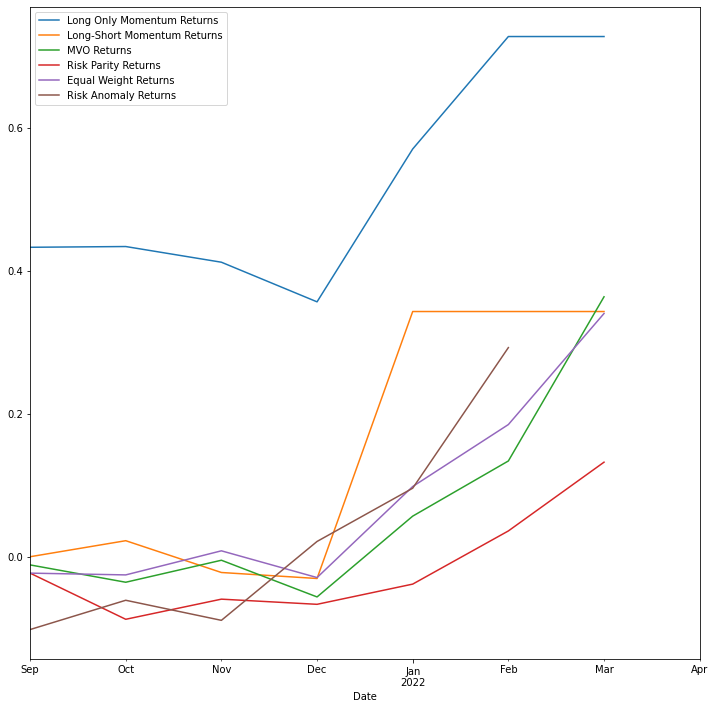

In [13]:
final_df, tracking_df = strategy_returns(start)
tracking_df

In [14]:
tracking_df[["Date", "Strategy", "Weights"]].groupby(["Date", "Strategy"]).sum()

Weights
Date       Strategy                    
2021-08-22 Long Only Momentum       1.0
           Long Short Momentum      0.0
           MVO                      1.0
           Risk Parity              1.0
2021-09-22 Long Only Momentum       1.0
           Long Short Momentum      1.0
           MVO                      1.0
           Risk Anomaly             1.0
           Risk Parity              1.0
2021-10-22 Long Only Momentum       1.0
           Long Short Momentum      1.0
           MVO                      1.0
           Risk Anomaly             1.0
           Risk Parity              1.0
2021-11-22 Long Only Momentum       1.0
           Long Short Momentum      1.0
           MVO                      1.0
           Risk Anomaly             1.0
           Risk Parity              1.0
2021-12-22 Long Only Momentum       1.0
           Long Short Momentum      1.0
           MVO                      1.0
           Risk Anomaly             1.0
           Risk Parity              1.0
2022-01-22 Long Only Momentum       1.0
           Long Short Momentum      1.0
           MVO                      1.0
           Risk Anomaly             1.0
           Risk Parity              1.0
2022-02-22 Long Only Momentum       1.0
           Long Short Momentum      0.0
           MVO                      1.0
           Risk Anomaly             1.0
           Risk Parity              1.0
2022-03-22 Long Only Momentum       0.0
           Long Short Momentum      0.0
           MVO                      1.0
           Risk Anomaly             1.0
           Risk Parity              1.0
2022-04-22 Long Only Momentum       1.0
           Long Short Momentum      1.0
           MVO                      1.0
           Risk Anomaly             0.0
           Risk Parity              1.0

In [15]:
data_w_cateogry = get_coin_category(tracking_df)
data_w_cateogry.to_csv('data_w_cateogry_final.csv', index=False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:127: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


### **Part 4 Hedging Part**

[*********************100%***********************]  1 of 1 completed


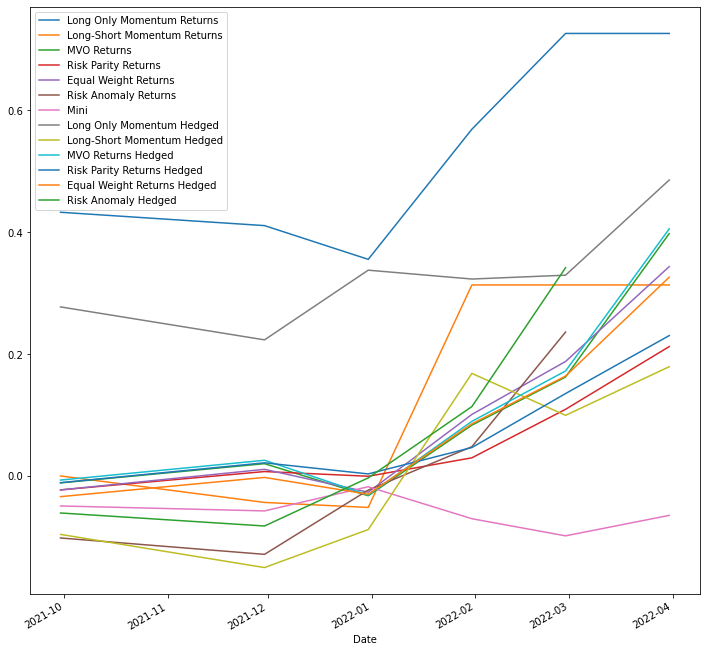

In [16]:
#downloading mini and calculating the beta of each strategy
mini = yf.download("ES=F")[['Close']]
mini = mini.pct_change(freq = '1M').dropna(axis=0, how="all")
all_returns = pd.merge(final_df, mini, left_index=True, right_index=True)
all_returns.rename(columns = {'Close': 'Mini'}, inplace = True)
strats_beta = all_returns.cov()['Mini']/all_returns['Mini'].var()

#calculating returns of hedged portfolios (don't need the weights, we're just assuming we long/short the futures based on a certain % of our portfolio, which is determined by the beta)
all_returns['Long Only Momentum Hedged'] = all_returns['Long Only Momentum Returns'] - strats_beta['Long Only Momentum Returns'] * all_returns['Mini']
all_returns['Long-Short Momentum Hedged'] = all_returns['Long-Short Momentum Returns'] - strats_beta['Long-Short Momentum Returns'] * all_returns['Mini']
all_returns['MVO Returns Hedged'] = all_returns['MVO Returns'] - strats_beta['MVO Returns'] * all_returns['Mini']
all_returns['Risk Parity Returns Hedged'] = all_returns['Risk Parity Returns'] - strats_beta['Risk Parity Returns'] * all_returns['Mini']
all_returns['Equal Weight Returns Hedged'] = all_returns['Equal Weight Returns'] - strats_beta['Equal Weight Returns'] * all_returns['Mini']
all_returns['Risk Anomaly Hedged'] = all_returns['Risk Anomaly Returns'] - strats_beta['Risk Anomaly Returns'] * all_returns['Mini']
all_returns.add(1).cumprod().sub(1).plot(figsize=(12,12))

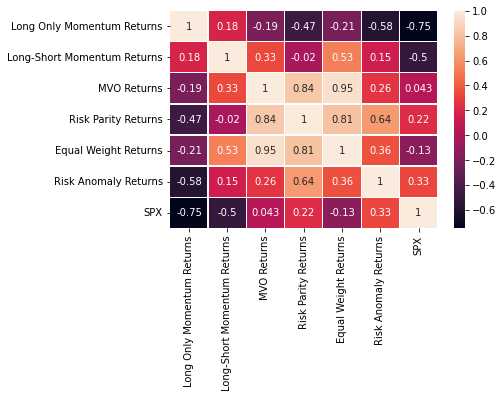

In [17]:
#pre-hedge correlation
non_hedged = all_returns.iloc[:,:7]
non_hedged.rename(columns={"Mini": "SPX"}, inplace = True)
sns.heatmap(non_hedged.corr(), annot= True,linewidths=.2)

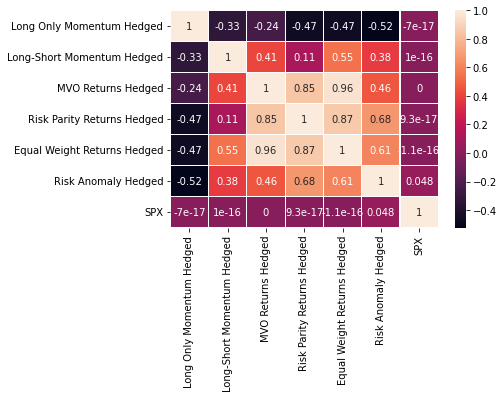

In [18]:
#calculating the correlations post-hedge to show that our hedging works
only_hedged = all_returns.iloc[:,7:]
only_hedged['SPX'] = all_returns['Mini']
sns.heatmap(only_hedged.corr(), annot= True,linewidths=.2)

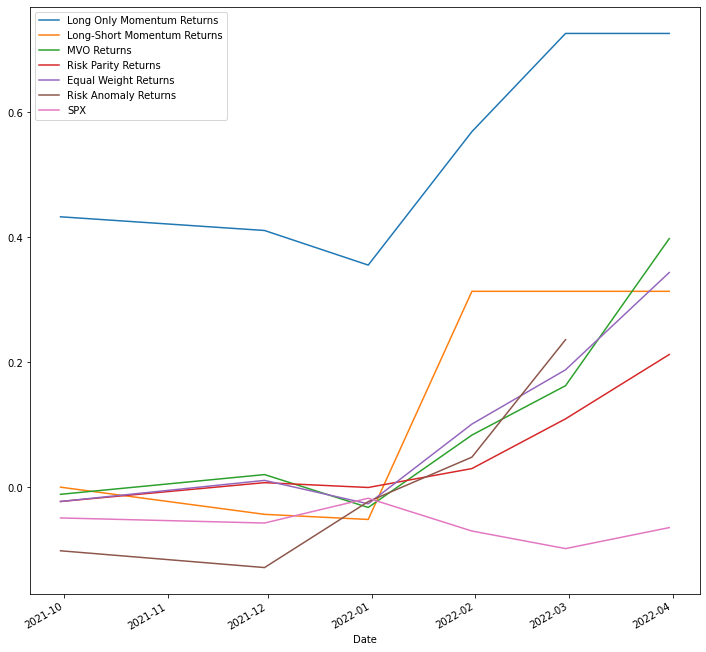

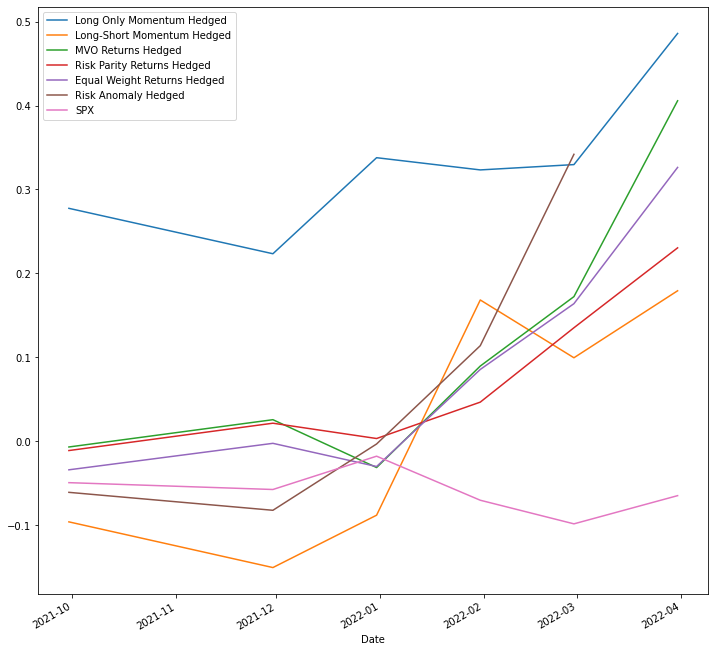

In [19]:
#plotting the cumulative returns
non_hedged.add(1).cumprod().sub(1).plot(figsize=(12,12))
only_hedged.add(1).cumprod().sub(1).plot(figsize=(12,12))